### Question 1
What are the busiest times of the year to visit Boston?

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,normalize
from sklearn.cluster import KMeans
%matplotlib inline

In [44]:
df_calendar = pd.read_csv('boston/calendar.csv')

In [45]:
df_calendar.head()

listing_id        date available price
0    12147973  2017-09-05         f   NaN
1    12147973  2017-09-04         f   NaN
2    12147973  2017-09-03         f   NaN
3    12147973  2017-09-02         f   NaN
4    12147973  2017-09-01         f   NaN

### Data Check

In [46]:
df_calendar.dtypes # we need change the price to float

listing_id     int64
date          object
available     object
price         object
dtype: object

In [6]:
df_calendar['available'].value_counts(dropna=False)

f    665853
t    643037
Name: available, dtype: int64

In [6]:
#check consistance
#price and available are highly correlated
df_calendar['price'][df_calendar['available']=='f'].isnull().mean() #should be all NaN

1.0

In [7]:
df_calendar['price'][df_calendar['available']=='t'].isnull().mean() #should all none NaN

0.0

Price is object, need to change to float

In [47]:
#make all price to str
df_calendar['price'] = df_calendar['price'].astype('str')

In [48]:
df_calendar.head()

listing_id        date available price
0    12147973  2017-09-05         f   nan
1    12147973  2017-09-04         f   nan
2    12147973  2017-09-03         f   nan
3    12147973  2017-09-02         f   nan
4    12147973  2017-09-01         f   nan

In [49]:
def dollar_to_float(price):
    #
    if price=='nan':
        return np.nan
    res = ""
    for s in price:
        if s !='$' and s !=',':
            res += s
    return float(res)

In [50]:
#change the price to float 
df_calendar['price'] = df_calendar['price'].apply(dollar_to_float)

In [51]:
df_calendar.head()

listing_id        date available  price
0    12147973  2017-09-05         f    NaN
1    12147973  2017-09-04         f    NaN
2    12147973  2017-09-03         f    NaN
3    12147973  2017-09-02         f    NaN
4    12147973  2017-09-01         f    NaN

In [52]:
#check the NaN 
df_calendar[['listing_id','date','available']].isnull().mean()

listing_id    0.0
date          0.0
available     0.0
dtype: float64

In [53]:
#map the available to True or False
df_calendar['available'] = df_calendar['available'].map({'t':True,'f':False})

In [54]:
df_calendar.dtypes

listing_id      int64
date           object
available        bool
price         float64
dtype: object

In [55]:
#change str date to datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'],format='%Y-%m-%d')

In [56]:
df_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [57]:
df_calendar.head()

listing_id       date  available  price
0    12147973 2017-09-05      False    NaN
1    12147973 2017-09-04      False    NaN
2    12147973 2017-09-03      False    NaN
3    12147973 2017-09-02      False    NaN
4    12147973 2017-09-01      False    NaN

In [58]:
df_calendar.set_index('date',inplace=True) #set index to be the date

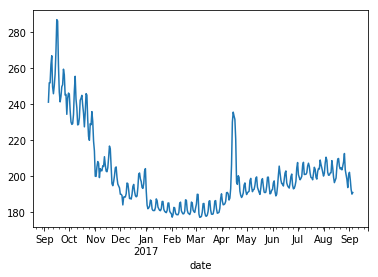

In [59]:
#check mean price by day
df_calendar['price'].resample('D').mean().plot();

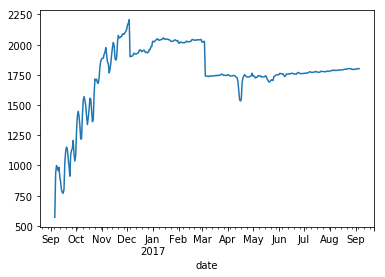

In [60]:
#let's check the available listing per day
# number of available listing and mean price seems 
#having strong correlation
df_calendar.resample('D')['available'].sum().plot();

In [61]:
#they seems to be anticorrolated , let's plot them together
#but normlize first
price_mean_per_day=df_calendar['price'].resample('D').mean()
avai_sum_per_day=df_calendar.resample('D')['available'].sum()

In [62]:
avai_sum_per_day_mean = avai_sum_per_day.mean()
avai_sum_per_day_std=avai_sum_per_day.std()
price_mean_per_day_mean = price_mean_per_day.mean()
price_mean_per_day_std=price_mean_per_day.std()

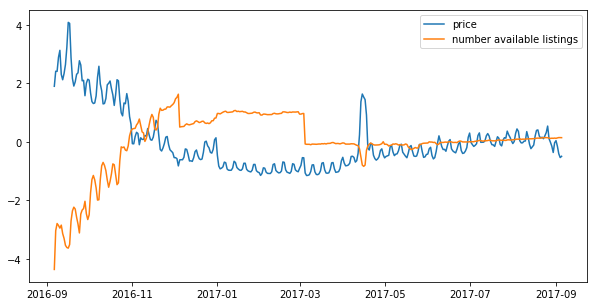

In [63]:
plt.figure(figsize=(10,5))
plt.plot(price_mean_per_day.index,(price_mean_per_day.values-price_mean_per_day_mean)/price_mean_per_day_std,label='price');
plt.plot(avai_sum_per_day.index,(avai_sum_per_day.values-avai_sum_per_day_mean)/avai_sum_per_day_std,label='number available listings');
plt.legend(loc='upper right');

the price and number of available listings are strongly correlated: when number of available listings increases,
the price drops, which may be a result of comptition.The number of available listings peaks at December,this may imply a busiest time of visiting boston. For the price,we can see some fluctuation, let's check by week day

In [64]:
df_calendar = df_calendar.reset_index()

In [65]:
df_calendar['day_of_week'] = df_calendar['date'].dt.day_name()

In [66]:
df_calendar.groupby('day_of_week')['price'].mean()

day_of_week
Friday       203.121167
Monday       195.809561
Saturday     203.408387
Sunday       198.219764
Thursday     198.073112
Tuesday      195.173842
Wednesday    195.418228
Name: price, dtype: float64

In [67]:
df_calendar.groupby('day_of_week')['available'].sum()

day_of_week
Friday       90998.0
Monday       92413.0
Saturday     91068.0
Sunday       92208.0
Thursday     91202.0
Tuesday      93332.0
Wednesday    91816.0
Name: available, dtype: float64

In [68]:
price_mean_per_day=price_mean_per_day.reset_index()

In [69]:
price_mean_per_day['day_of_week'] = price_mean_per_day['date'].dt.day_name()
price_mean_per_day['day_of_week_n'] =price_mean_per_day['date'].dt.dayofweek

In [70]:
price_mean_per_day.head()

date       price day_of_week  day_of_week_n
0 2016-09-06  241.043860     Tuesday              1
1 2016-09-07  251.833691   Wednesday              2
2 2016-09-08  251.748749    Thursday              3
3 2016-09-09  261.859327      Friday              4
4 2016-09-10  266.847280    Saturday              5

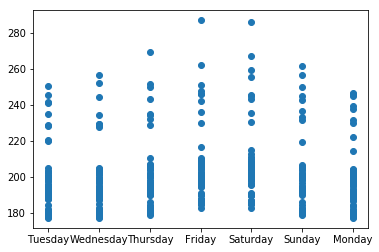

In [72]:
#it looks like Friday and Saturday have the highest price, this may indicate more people arrive at Friday and 
#Saturday
plt.scatter(price_mean_per_day['day_of_week'],price_mean_per_day['price']);

it looks like Friday and Saturday have the highest price, this may indicate more people arrive at Friday and 
Saturday

### Let's check the available listing in different area in different month

In [73]:
#reading list information
df_listings = pd.read_csv('boston/listings.csv')

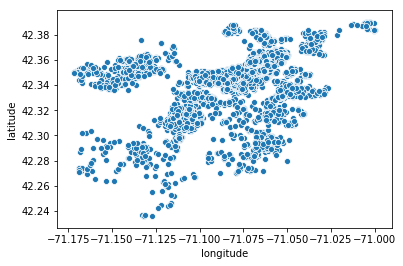

In [74]:
sb.scatterplot(x='longitude',y='latitude',data=df_listings)

In [61]:
df_listings.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview        ...          \
0  Roslindale is quiet, convenient and friendly. ...        ...           
1  The room is in Roslindale, a diverse and prima...        ...           
2  The LOCATION: Roslindale is a safe and diverse...        ...           
3  Roslindale is a lovely little neighborhood loc...        ...           
4  I love the proximity to downtown, the neighbor...        ...           

  review_scores_value requires_license license jurisdiction_names  \
0                 NaN                f     NaN                NaN   
1                 9.0                f     NaN                NaN   
2                10.0                f     NaN                NaN   
3                10.0                f     NaN                NaN   
4                10.0                f     NaN                NaN   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                f            moderate                             f   
1                t            moderate                             f   
2                f            moderate                             t   
3                f            moderate                             f   
4                f            flexible                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              1   
2                                f                              1   
3                                f                              1   
4                                f                              1   

   reviews_per_month  
0                NaN  
1               1.30  
2               0.47  
3               1.00  
4               2.25  

[5 rows x 95 columns]

In [75]:
#we only interested in position
df_list_pos = df_listings[['id','longitude','latitude']].copy()

In [77]:
#changing the name id to listing_id
df_list_pos=df_list_pos.rename({'id':'listing_id','longitude':'longitude','latitude':'latitude'},axis='columns')

In [78]:
df_list_pos.shape

(3585, 3)

In [79]:
#merge the position information
df_merge = pd.merge(df_calendar,df_list_pos,how='inner',on='listing_id')

In [80]:
df_merge.head()

date  listing_id  available  price day_of_week  longitude   latitude
0 2017-09-05    12147973      False    NaN     Tuesday -71.133068  42.282619
1 2017-09-04    12147973      False    NaN      Monday -71.133068  42.282619
2 2017-09-03    12147973      False    NaN      Sunday -71.133068  42.282619
3 2017-09-02    12147973      False    NaN    Saturday -71.133068  42.282619
4 2017-09-01    12147973      False    NaN      Friday -71.133068  42.282619

In [81]:
#create a new column of year month
df_merge['year_month']=df_merge.date.map(lambda x: x.strftime('%Y-%m'))

In [82]:
#let's check how many month do we have
df_merge['year_month'].value_counts()

2017-08    111166
2017-07    111166
2016-12    111166
2017-01    111166
2016-10    111166
2017-03    111166
2017-05    111166
2016-11    107580
2017-04    107580
2017-06    107580
2017-02    100408
2016-09     89650
2017-09     17930
Name: year_month, dtype: int64

In [83]:
df_merge.dtypes

date           datetime64[ns]
listing_id              int64
available                bool
price                 float64
day_of_week            object
longitude             float64
latitude              float64
year_month             object
dtype: object

In [84]:
year_month_list=['2016-09','2016-10','2016-11','2016-12','2017-01','2017-02',
                 '2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09']

In [85]:
len(year_month_list)

13

In [87]:
year_month_days_list=[]
for m in year_month_list:
    k = df_merge[df_merge['year_month']==m]['date'].value_counts().shape[0]
    year_month_days_list.append(k)
    

In [88]:
#the last month has only about 5 days we will ignore
year_month_days_list

[25, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 5]

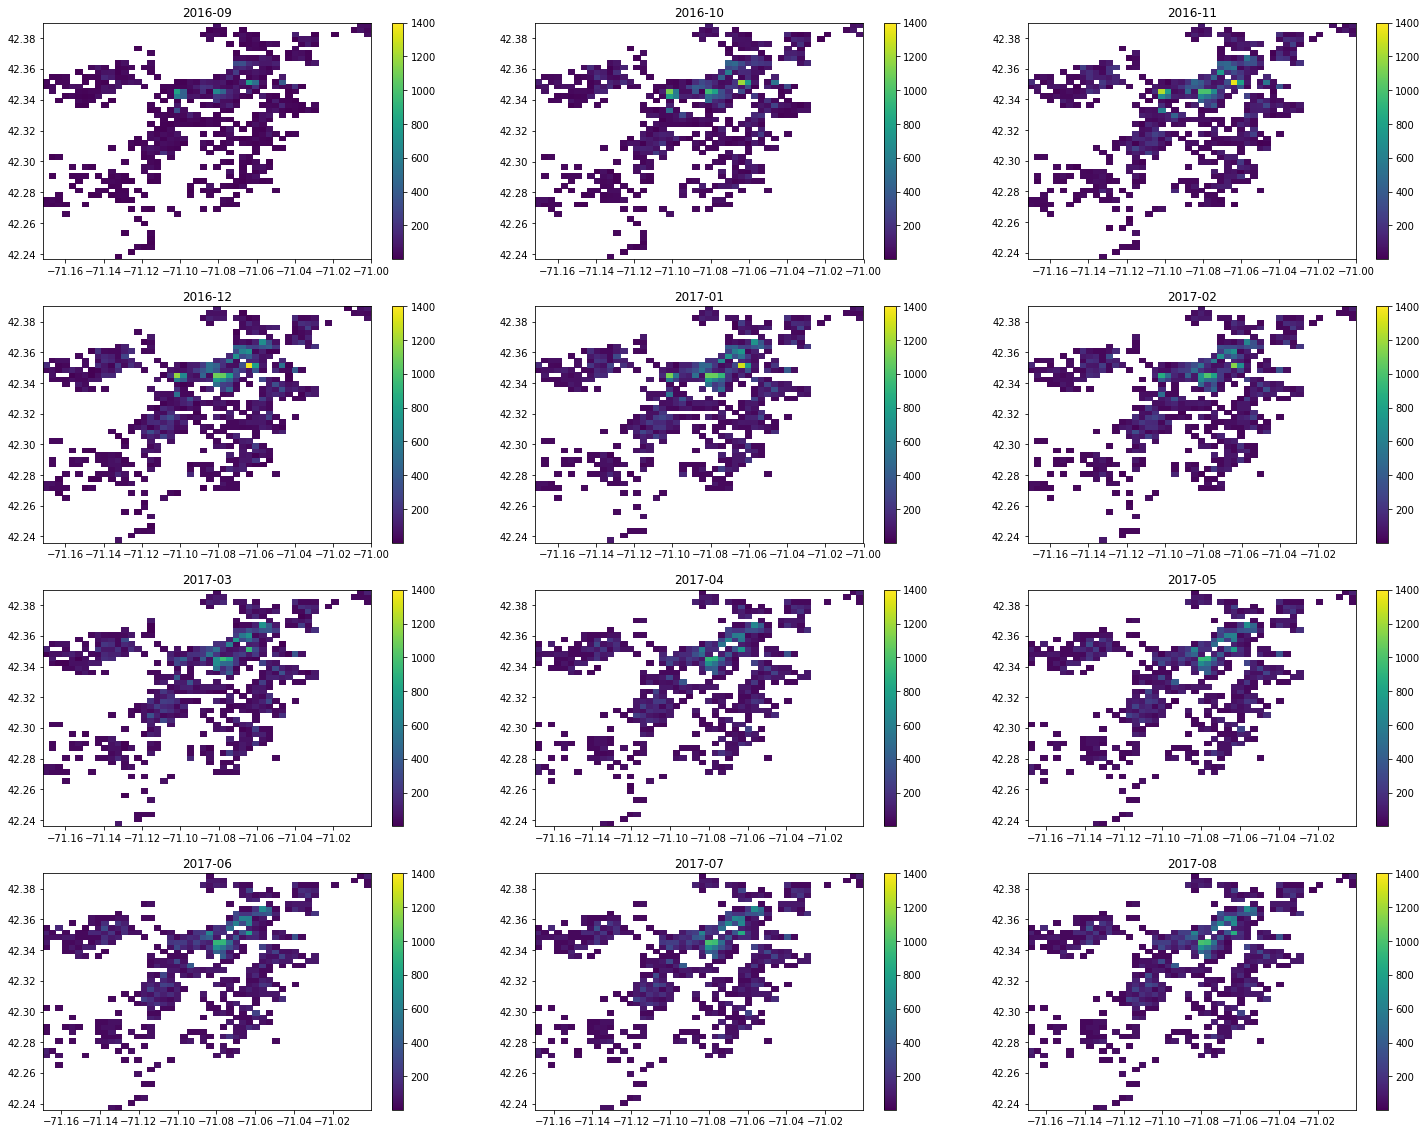

In [99]:
f,axarr = plt.subplots(4,3)
f.set_figheight(20)
f.set_figwidth(25)
for i in range(4):
    for j in range(3):
        index = j+3*i
        #print('yearmonth '+year_month_list[index])
        #print('day ',year_month_days_list[index])
        df_merge_month = df_merge[df_merge['year_month']==year_month_list[index]]
        h = axarr[i][j].hist2d(cmin=2,bins=50,x=df_merge_month[df_merge_month['available']==True]['longitude'],
              y=df_merge_month[df_merge_month['available']==True]['latitude'],vmin=2,vmax=1400)
        axarr[i][j].set_title(year_month_list[index]);
        plt.colorbar(h[3], ax=axarr[i][j]);
        

We can see the number of available listings in different area accrossing the year

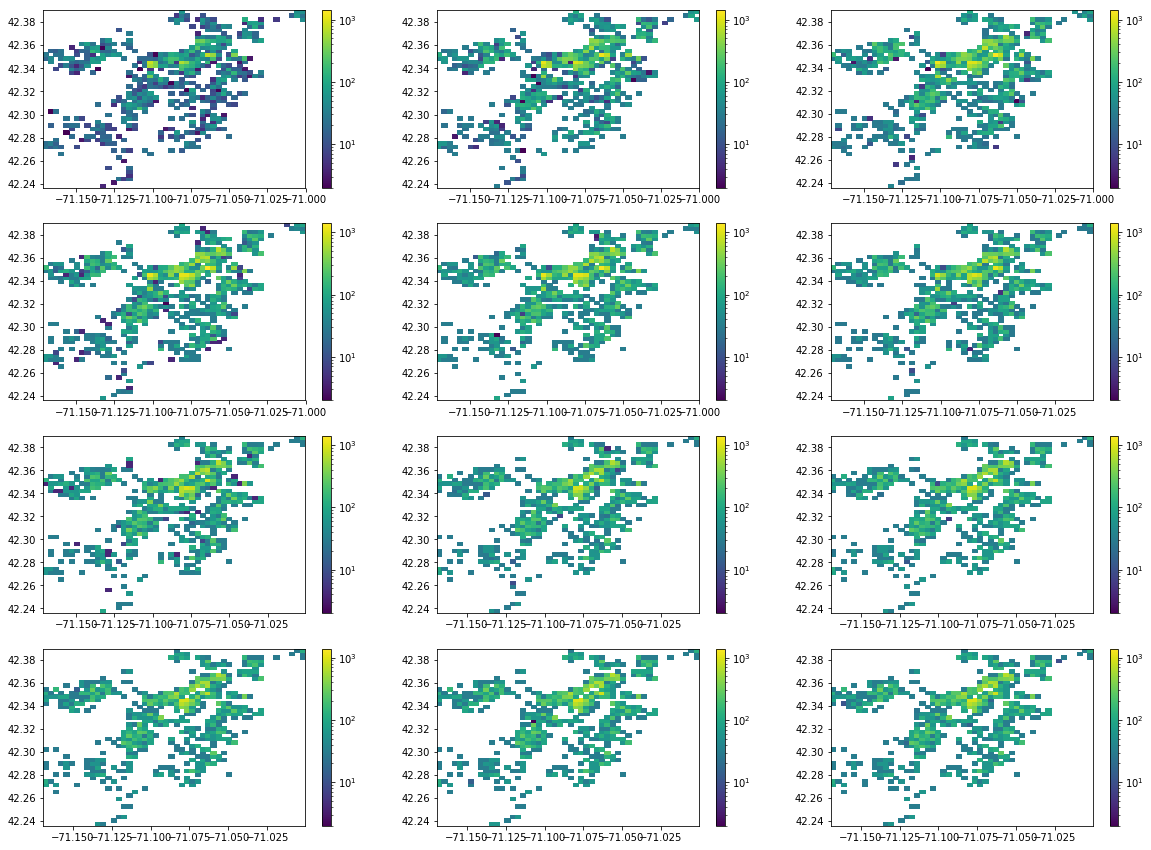

In [101]:
#let's see a log scale
f,axarr = plt.subplots(4,3)
f.set_figheight(15)
f.set_figwidth(20)
for i in range(4):
    for j in range(3):
        index = j+3*i
        #print('yearmonth '+year_month_list[index])
        #print('day ',year_month_days_list[index])
        df_merge_month = df_merge[df_merge['year_month']==year_month_list[index]]
        length = df_merge_month[df_merge_month['available']==True].shape[0]
        w = [1./year_month_days_list[index] for s in range(length)]
        h = axarr[i][j].hist2d(cmin=2,bins=50,x=df_merge_month[df_merge_month['available']==True]['longitude'],
              y=df_merge_month[df_merge_month['available']==True]['latitude'],vmin=2,vmax=1400,norm=mpl.colors.LogNorm())
        plt.colorbar(h[3], ax=axarr[i][j]);

We can see available listings start at center area and then spread to the eadge of the area. Most available is located at center area.